# Thiết lập chung

In [1]:
DATA_ROOT = "/kaggle/input"
WORK_DIR = "/kaggle/working"
CACHE_DIR = f"{WORK_DIR}/slice_cache"

# chọn 1 trong 3: "axial", "coronal", "sagittal"
CURRENT_VIEW = "axial"  # 

# Cấu hình cho từng view 
VIEW_CONFIG = {
    "axial": {"slices": 16, "start_frac": 0.1, "end_frac": 0.9, "target_size": (224, 224)},
    "coronal": {"slices": 32, "start_frac": 0.1, "end_frac": 0.9, "target_size": (224, 224)},
    "sagittal": {"slices": 32, "start_frac": 0.1, "end_frac": 0.9, "target_size": (224, 224)}
}

# Lấy config cho view hiện tại
CONFIG = VIEW_CONFIG[CURRENT_VIEW]

# Siêu tham số
BATCH_SIZE = 4
LEARNING_RATE = 2e-4
EPOCHS = 10
THRESHOLD = 0.42
NUM_FOLDS = 8

# Bệnh nhân
patient_id_to_check = "003_S_1257"
topK = 5

# Thư viện

In [2]:
!pip install -q  nibabel scikit-learn matplotlib pandas

In [3]:
import os
import re

import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import densenet121, DenseNet121_Weights

from sklearn.model_selection import StratifiedGroupKFold, train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

import nibabel as nib
from scipy.ndimage import zoom
from nibabel.processing import resample_to_output


PATIENT_INDEX = {}
PATIENT_LABELS = {}
MODEL = None
DEVICE = None

os.makedirs(CACHE_DIR, exist_ok=True)

In [4]:

def clean_old_models():
    """Xóa tất cả file best model cũ"""
    
    patterns = [
        f"{WORK_DIR}/best_{CURRENT_VIEW}_model.pth",
        f"{WORK_DIR}/best_{CURRENT_VIEW}_fold*_model.pth",
        f"{WORK_DIR}/best_{CURRENT_VIEW}_epoch*_model.pth"
    ]
    
    deleted_files = []
    for pattern in patterns:
        for file_path in glob.glob(pattern):
            try:
                os.remove(file_path)
                deleted_files.append(os.path.basename(file_path))
                print(f"✓ Đã xóa: {os.path.basename(file_path)}")
            except Exception as e:
                print(f"⚠️ Không thể xóa {file_path}: {e}")
    
    if not deleted_files:
        print("Không có file best model cũ để xóa")
    else:
        print(f"Đã xóa {len(deleted_files)} file best model cũ")

# Gọi hàm xóa
clean_old_models()

Không có file best model cũ để xóa


In [5]:
def set_seed(seed=7):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(7)

# Chuẩn bị dữ liệu

In [6]:
def extract_image_id_from_path(file_path):
    filename = os.path.basename(file_path)
    m = re.search(r"(I\d+)", filename)
    return m.group(1) if m else None


def find_nii_files(root_dir):
    """Tìm tất cả file .nii trong thư mục"""
    print(f"Đang tìm trong: {root_dir}")
    print(f"Thư mục có tồn tại? {os.path.exists(root_dir)}")
    
    if os.path.exists(root_dir):
        print("\nCấu trúc thư mục:")
        for item in os.listdir(root_dir):
            print(f"  - {item}")
    
    nii_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                nii_files.append(os.path.join(root, file))
    
    print(f"\nTổng file NIfTI tìm thấy: {len(nii_files)}")
    
    # Debug: in ra vài file đầu tiên
    if len(nii_files) > 0:
        print("\nVí dụ file tìm thấy:")
        for fp in nii_files[:3]:
            print(f"  {fp}")
    
    return nii_files


def prepare_data():
    # ===== Đọc CSV =====
    abb_df = pd.read_csv(f"{DATA_ROOT}/abb_9_13_2025.csv")
    ecc_df = pd.read_csv(f"{DATA_ROOT}/ecc_9_20_2025.csv")

    # ===== Tạo mapping ImageID -> label =====
    def get_imgid_col(df):
        for c in df.columns:
            if "image" in c.lower() and "id" in c.lower():
                return c
        raise ValueError("Không tìm thấy cột Image Data ID")

    img_col_abb = get_imgid_col(abb_df)
    img_col_ecc = get_imgid_col(ecc_df)

    image_label = {}

    # ABB = AD (1)
    for v in abb_df[img_col_abb].astype(str):
        image_label[v.strip()] = 1

    # ECC = CN (0)
    for v in ecc_df[img_col_ecc].astype(str):
        image_label[v.strip()] = 0

    print("Số ImageID trong CSV:", len(image_label))
    print("\nVí dụ ImageID từ CSV:")
    for i, img_id in enumerate(list(image_label.keys())[:5]):
        print(f"  {img_id} -> label={image_label[img_id]}")

    # ===== Tìm tất cả file nii =====
    root_dir = f"{DATA_ROOT}"
    all_nii = find_nii_files(root_dir)

    if len(all_nii) == 0:
        print("\n⚠️ KHÔNG TÌM THẤY FILE NÀO!")
        print("Thử kiểm tra các đường dẫn khả năng:")
        possible_paths = [
            f"{DATA_ROOT}",
            f"{DATA_ROOT}/abb",
            f"{DATA_ROOT}/ecc",
        ]
        for path in possible_paths:
            if os.path.exists(path):
                print(f"✓ Tồn tại: {path}")
                files = os.listdir(path)[:5]
                print(f"  Nội dung: {files}")
            else:
                print(f"✗ Không tồn tại: {path}")
        return [], [], []

    # ===== Nhóm file theo patient và lấy file đầu tiên =====
    patient_files = {}
    
    print(f"\n🔍 Bắt đầu xử lý {len(all_nii)} file...")
    matched_count = 0
    
    for fp in all_nii:
        # Extract image ID từ tên file
        img_id = extract_image_id_from_path(fp)
        
        if img_id is None:
            continue
            
        if img_id not in image_label:
            continue
        
        matched_count += 1
        
        # Extract patient ID từ đường dẫn
        parts = fp.split(os.sep)
        try:
            adni_idx = parts.index("ADNI")
            pid = parts[adni_idx + 1]
        except (ValueError, IndexError):
            print(f"⚠️ Không tìm thấy 'ADNI' trong đường dẫn: {fp}")
            continue
        
        # Chỉ lấy file đầu tiên của mỗi patient
        if pid not in patient_files:
            patient_files[pid] = (fp, image_label[img_id])
            if len(patient_files) <= 3:
                print(f"  ✓ Patient {pid}: {os.path.basename(fp)} (label={image_label[img_id]})")

    print(f"\n📊 Kết quả matching:")
    print(f"  File có ImageID khớp CSV: {matched_count}")
    print(f"  Số patient unique: {len(patient_files)}")

    # ===== Tách ra lists =====
    all_files = []
    all_labels = []
    patient_ids = []
    
    for pid, (fp, label) in patient_files.items():
        all_files.append(fp)
        all_labels.append(label)
        patient_ids.append(pid)

    print("\nSau khi lấy 1 file đầu tiên mỗi patient:")
    print("Tổng mẫu:", len(all_files))
    print("AD:", sum(all_labels))
    print("CN:", len(all_labels) - sum(all_labels))

    return all_files, all_labels, patient_ids

In [7]:
def build_patient_index(file_paths, patient_ids, labels):
    index = {}
    label_map = {}
    for pid, fp, label in zip(patient_ids, file_paths, labels):
        if pid not in index:
            index[pid] = fp
            label_map[pid] = label
    return index, label_map

# Xử lý dữ liệu

In [8]:
def load_volume(nii_path):
    """Đọc file NIfTI"""
    img = nib.load(nii_path)
    img = nib.as_closest_canonical(img)
    img = resample_to_output(img, voxel_sizes=(1,1,1))
    vol = img.get_fdata().astype(np.float32)
    return vol

def normalize_volume(vol):
    """Normalize z-score trên vùng não"""
    brain_mask = vol > 0
    if not np.any(brain_mask):
        return vol
    brain_values = vol[brain_mask]
    mean = np.mean(brain_values)
    std = np.std(brain_values)
    out = vol.copy()
    out[brain_mask] = (out[brain_mask] - mean) / (std + 1e-6)
    return out

def brain_bbox_2d(slice2d, margin=10):
    """Tìm bounding box của não"""
    # Tạo mask đơn giản
    thr = np.percentile(slice2d[slice2d > 0], 10) if np.any(slice2d > 0) else 0
    mask = slice2d > thr
    
    if not np.any(mask):
        return None
    
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    
    if not np.any(rows) or not np.any(cols):
        return None
    
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    # Thêm margin
    rmin = max(0, rmin - margin)
    rmax = min(slice2d.shape[0] - 1, rmax + margin)
    cmin = max(0, cmin - margin)
    cmax = min(slice2d.shape[1] - 1, cmax + margin)
    
    return (rmin, rmax, cmin, cmax)

def pad_to_shape(slice2d, target_h, target_w):
    """Pad slice về target size"""
    h, w = slice2d.shape
    
    # CROP nếu quá lớn
    if h > target_h:
        start_h = (h - target_h) // 2
        slice2d = slice2d[start_h:start_h + target_h, :]
        h = target_h
    
    if w > target_w:
        start_w = (w - target_w) // 2
        slice2d = slice2d[:, start_w:start_w + target_w]
        w = target_w
    
    # PAD nếu quá nhỏ
    pad_h = target_h - h
    pad_w = target_w - w
    
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    
    return np.pad(
        slice2d,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode='constant',
        constant_values=0
    )

def crop_then_pad(slice2d, target_h=224, target_w=224, view=None):
    """Skull stripping với view-specific adjustments"""
    bb = brain_bbox_2d(slice2d, margin=12)
    
    if bb is not None:
        y0, y1, x0, x1 = bb

        # View-specific adjustments (giống code tham khảo của bạn)
        if view == "axial":
            w = x1 - x0 + 1
            x1 = x1 - int(0.15 * w)
        elif view == "coronal":
            w = x1 - x0 + 1
            x0 = x0 + int(0.40 * w)
        elif view == "sagittal":
            h = y1 - y0 + 1
            w = x1 - x0 + 1
            x0 = x0 + int(0.28 * h)  # cổ
            y1 = y1 - int(0.10 * w)  # mặt

        # Safety check
        if y1 <= y0 or x1 <= x0:
            y0, y1, x0, x1 = bb

        slice2d = slice2d[y0:y1+1, x0:x1+1]

    # Resize về target size
    return pad_to_shape(slice2d, target_h, target_w)

def process_single_file(nii_path, view_type=CURRENT_VIEW):
    """Pipeline xử lý cho 1 file MRI + CACHE"""

    # CACHE CHECK 
    safe_name = nii_path.replace("/", "_").replace(".nii.gz", "").replace(".nii", "")
    cache_path = os.path.join(CACHE_DIR, f"{safe_name}_{view_type}.npy")

    if os.path.exists(cache_path):
        return np.load(cache_path), None

    # LOAD & NORMALIZE
    vol = load_volume(nii_path)
    vol = normalize_volume(vol)

    # EXTRACT SLICES 
    if view_type == "axial":
        all_slices = [vol[:, :, z] for z in range(vol.shape[2])]
    elif view_type == "coronal":
        all_slices = [vol[:, y, :] for y in range(vol.shape[1])]
    elif view_type == "sagittal":
        all_slices = [vol[x, :, :] for x in range(vol.shape[0])]
    else:
        raise ValueError(f"View không hợp lệ: {view_type}")

    # SAMPLE ĐỀU 
    n = len(all_slices)
    start_idx = int(n * CONFIG['start_frac'])
    end_idx = int(n * CONFIG['end_frac'])

    if end_idx <= start_idx:
        start_idx, end_idx = 0, n

    indices = np.linspace(start_idx, end_idx - 1, CONFIG['slices']).astype(int)
    sampled_slices = [all_slices[i] for i in indices]

    # PROCESS TỪNG SLICE 
    processed_slices = []
    for slice_2d in sampled_slices:
        processed = crop_then_pad(
            slice_2d,
            target_h=CONFIG['target_size'][0],
            target_w=CONFIG['target_size'][1],
            view=view_type
        )
        processed_slices.append(processed)

    # STACK
    processed_array = np.stack(processed_slices, axis=0)   # (S, H, W)
    processed_array = np.expand_dims(processed_array, axis=1)  # (S, 1, H, W)
    processed_array = processed_array.astype(np.float32)

    # SAVE CACHE
    np.save(cache_path, processed_array)

    return processed_array, indices

In [9]:
def check_preprocessing(patient_id, view="axial", slice_idx=8):
    """
    So sánh RAW vs PROCESSED cho 1 SLICE
    """
    if patient_id not in PATIENT_INDEX:
        print(f"Không tìm thấy patient: {patient_id}")
        return
    
    nii_path = PATIENT_INDEX[patient_id]
    print(f"==== CHECK PREPROCESSING ====")
    print(f"Patient: {patient_id}")
    print(f"File: {os.path.basename(nii_path)}")
    
    # LOAD RAW
    vol_raw = load_volume(nii_path)
    vol_norm = normalize_volume(vol_raw)
    
    # LOAD PROCESSED
    slices_processed, indices = process_single_file(nii_path, view)
    
    if indices is None:
        indices = list(range(slices_processed.shape[0]))
    
    # LẤY 1 SLICE
    real_slice_idx = indices[slice_idx]
    
    # RAW SLICE
    if view == "axial":
        raw_slice = vol_norm[:, :, real_slice_idx]
    elif view == "coronal":
        raw_slice = vol_norm[:, real_slice_idx, :]
    elif view == "sagittal":
        raw_slice = vol_norm[real_slice_idx, :, :]
    
    # PROCESSED SLICE
    proc_slice = slices_processed[slice_idx, 0]  # (H, W)
    
    # PLOT
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(raw_slice.T, cmap='gray', origin='lower', vmin=-3, vmax=3)
    axes[0].set_title(f"RAW | {view} | idx={real_slice_idx}")
    axes[0].axis('off')
    
    axes[1].imshow(proc_slice.T, cmap='gray', origin='lower', vmin=-3, vmax=3)
    axes[1].set_title(f"PROCESSED | skull stripped + resized")
    axes[1].axis('off')
    
    plt.suptitle(f"Patient {patient_id} | View: {view}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Mô hình hóa

In [10]:
# Thiết lập dữ liệu đầu vào 
class MRIDataset2D(Dataset):
    """Dataset cho MRI 2D slices"""
    def __init__(self, file_paths, labels, view_type=CURRENT_VIEW):
        self.file_paths = file_paths
        self.labels = labels
        self.view_type = view_type
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        nii_path = self.file_paths[idx]
        label = self.labels[idx]
        
        try:
            slices, _ = process_single_file(nii_path, self.view_type)
            slices_tensor = torch.from_numpy(slices).float()
            label_tensor = torch.tensor(label, dtype=torch.long)
            return slices_tensor, label_tensor, nii_path
        except Exception as e:
            print(f"Error processing {nii_path}: {e}")
            # Fallback
            slices_tensor = torch.zeros(CONFIG['slices'], 1, 
                                       CONFIG['target_size'][0], 
                                       CONFIG['target_size'][1])
            label_tensor = torch.tensor(0, dtype=torch.long)
            return slices_tensor, label_tensor, nii_path

In [11]:
class DenseNetSliceAttention(nn.Module):
    """
    DenseNet121 pretrained + TRUE inter-slice self-attention (S×S)
    Tối ưu batch cho B×S slices (rất quan trọng)
    """
    def __init__(self, num_slices, num_classes=2, num_heads=4):
        super().__init__()

        # DenseNet backbone
        weights = DenseNet121_Weights.DEFAULT
        base = densenet121(weights=weights)

        # sửa conv đầu vào từ 3 channel -> 1 channel
        old_conv = base.features.conv0
        base.features.conv0 = nn.Conv2d(
            1,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        # khởi tạo trọng số bằng trung bình 3 kênh RGB
        with torch.no_grad():
            base.features.conv0.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)

        num_features = base.classifier.in_features
        base.classifier = nn.Identity()
        self.backbone = base

        # ===== Self-attention giữa slices =====
        self.slice_attention = nn.MultiheadAttention(
            embed_dim=num_features,
            num_heads=num_heads,
            batch_first=True
        )

        # ===== Classifier =====
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """
        x: (B, S, 1, H, W)
        """
        B, S, C, H, W = x.shape

      
        x = x.view(B * S, 1, H, W)        # (B*S, 1, H, W)

        F = self.backbone(x)              # (B*S, D)

        F = F.view(B, S, -1)             # (B, S, D)

        # ===== Attention S × S =====
        F_attn, attn_map = self.slice_attention(F, F, F)
        # attn_map shape: (B, S, S)

        pooled = F_attn.mean(dim=1)      # (B, D)

        logits = self.classifier(pooled)

        return logits, attn_map

In [12]:
def plot_training_history(history):
    """
    Vẽ biểu đồ Loss và Accuracy theo epoch
    history: dict với keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # LOSS
    ax1.plot(epochs, history['train_loss'], 'b-o', linewidth=2, label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-s', linewidth=2, label='Val Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # ACCURACY
    ax2.plot(epochs, history['train_acc'], 'g-o', linewidth=2, label='Train Accuracy')
    ax2.plot(epochs, history['val_acc'], 'm-s', linewidth=2, label='Val Accuracy')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [13]:
# Huấn luyện và đánh giá 
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for slices, labels, _ in loader:
        slices = slices.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(slices)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion, device, threshold=THRESHOLD):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for slices, labels, _ in loader:
            slices = slices.to(device)
            labels = labels.to(device)
            
            logits, _ = model(slices)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            probs = F.softmax(logits, dim=1)
            preds = (probs[:, 1] > threshold).long()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return {
        "loss": total_loss / len(loader),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(all_labels, all_preds),
        "probs": np.array(all_probs),
        "labels": np.array(all_labels)
    }

In [14]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, class_weights=None, fold=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )
    
    best_val_acc = -1.0
    best_state = None
    best_epoch = 0
    
    # ===== LƯU HISTORY =====
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Tên model dựa trên fold
    if fold is not None:
        model_name = f"best_{CURRENT_VIEW}_fold{fold}_model.pth"
    else:
        model_name = f"best_{CURRENT_VIEW}_model.pth"
    
    model_path = f"{WORK_DIR}/{model_name}"

    for epoch in range(1, epochs + 1):
        # Train 
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validate 
        val_results = validate(model, val_loader, criterion, device, threshold=THRESHOLD)
        val_loss = val_results["loss"]
        val_acc = val_results["accuracy"]
        
        # ===== LƯU VÀO HISTORY =====
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # ===== LƯU BEST MODEL SAU MỖI EPOCH =====
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_state = model.state_dict().copy()
            
            # Lưu model tốt nhất
            torch.save(best_state, model_path)
            print(f"  ✅ Đã lưu best model (epoch={epoch}, val_acc={best_val_acc:.4f})")
            
            # Lưu thêm checkpoint cho từng epoch tốt nhất
            epoch_model_path = f"{WORK_DIR}/best_{CURRENT_VIEW}_epoch{epoch}_acc{val_acc:.4f}.pth"
            torch.save(best_state, epoch_model_path)
            print(f"  📁 Lưu checkpoint: {os.path.basename(epoch_model_path)}")
        else:
            print(f"  ⏸️  Không cải thiện (best={best_val_acc:.4f} @ epoch={best_epoch})")

    print(f"\n🎯 Best model: epoch {best_epoch}, val_acc={best_val_acc:.4f}")
    print(f"💾 Model đã lưu: {model_name}")
    
    # Load lại best model
    if best_state is not None:
        model.load_state_dict(torch.load(model_path))
        print(f"✓ Đã load best model từ {model_name}")
    
    # ===== VẼ BIỂU ĐỒ =====
    plot_training_history(history)

    return model, best_val_acc

In [15]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.grad = None
        self.act = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.act = output

    def save_gradient(self, module, grad_input, grad_output):
        self.grad = grad_output[0]

    def __call__(self, x, slice_idx):
        self.model.zero_grad()

        logits, _ = self.model(x)
        score = logits[0,1]   # AD class
        score.backward()

        grad = self.grad[slice_idx]     # (C,H,W)
        act  = self.act[slice_idx]      # (C,H,W)

        weights = grad.mean(dim=(1,2), keepdim=True)
        cam = (weights * act).sum(dim=0)

        cam = F.relu(cam)
        cam = cam / cam.max()

        return cam.detach().cpu().numpy()

In [16]:
# Ma trận nhầm lẫn 
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    classes = ["CN", "AD"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_attention_weights(attn_weights, title="Attention Weights"):
    plt.figure(figsize=(10, 4))
    plt.plot(attn_weights.cpu().numpy(), 'o-', linewidth=2, markersize=8)
    plt.title(title)
    plt.xlabel('Slice Index')
    plt.ylabel('Attention Weight')
    plt.grid(True, alpha=0.3)
    plt.show()

In [17]:
def plot_attention_rollout(attn_map, title):
    A = attn_map

    # nếu là scalar → biến thành 1x1
    if A.ndim == 0:
        A = A.unsqueeze(0).unsqueeze(0)

    # nếu là vector → biến thành 1xN
    if A.ndim == 1:
        A = A.unsqueeze(0)

    plt.figure(figsize=(6,5))
    plt.imshow(A, cmap='viridis')
    plt.title(title)
    plt.xlabel("Slice")
    plt.ylabel("Slice")
    plt.colorbar()
    plt.show()

In [18]:
def query_patient(patient_id, top_k=5):
    if patient_id not in PATIENT_INDEX:
        print("Không có patient:", patient_id)
        return

    nii_path = PATIENT_INDEX[patient_id]
    true_label = "AD" if PATIENT_LABELS[patient_id] == 1 else "CN"
    
    print("==== PATIENT QUERY ====")
    print("Patient ID:", patient_id)
    print("True Label:", true_label)
    print("File:", os.path.basename(nii_path))

    # LOAD PROCESSED SLICES
    slices, indices = process_single_file(nii_path, CURRENT_VIEW)
    if indices is None:
        indices = list(range(slices.shape[0]))

    x = torch.from_numpy(slices).unsqueeze(0).to(DEVICE)

    # FORWARD MODEL
    with torch.no_grad():
        logits, attn = MODEL(x)
        prob = F.softmax(logits, dim=1)[0,1].item()

    pred_label = "AD" if prob > THRESHOLD else "CN"
    
    print("\n==== MODEL PREDICTION ====")
    print("Prediction :", pred_label)
    print("P(AD)      :", round(prob, 4))

    # ATTENTION ANALYSIS
    A = attn[0]
    if A.ndim == 0:
        A = A.unsqueeze(0).unsqueeze(0)
    importance = A.mean(dim=0)

    top_idx = np.argsort(importance.cpu().numpy())[::-1][:top_k]

    print(f"\n==== TOP {top_k} SLICES (ATTENTION) ====")
    
    # SETUP GRAD-CAM
    target_layer = MODEL.backbone.features.denseblock4.denselayer16.conv2
    grad_cam = GradCAM(MODEL, target_layer)

    # SHOW TOP SLICES
    for rank, idx in enumerate(top_idx, 1):
        idx = int(idx)
        slice_idx = indices[idx]
        
        print(f"Top {rank}: view={CURRENT_VIEW}, slice={slice_idx}, attn={float(importance[idx]):.4f}")

        # PROCESSED SLICE
        proc_slice = slices[idx, 0]  # (H, W)

        # GRAD-CAM
        cam = grad_cam(x, idx)
        
        # RESIZE CAM
        h, w = proc_slice.shape
        cam_h, cam_w = cam.shape
        cam_resized = zoom(cam, (h/cam_h, w/cam_w), order=1)

        # PLOT
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # PROCESSED - THÊM vmin/vmax
        axes[0].imshow(proc_slice.T, cmap='gray', origin='lower', vmin=-3, vmax=3)
        axes[0].set_title(f"PROCESSED | attn={importance[idx].item():.4f}")
        axes[0].axis('off')
        
        # GRAD-CAM OVERLAY
        axes[1].imshow(proc_slice.T, cmap='gray', origin='lower', alpha=0.7, vmin=-3, vmax=3)
        axes[1].imshow(cam_resized.T, cmap='jet', origin='lower', alpha=0.5)
        axes[1].set_title(f"GRAD-CAM HEATMAP")
        axes[1].axis('off')
        
        plt.suptitle(f"Top {rank} | Patient {patient_id} | Pred: {pred_label}", fontsize=14)
        plt.tight_layout()
        plt.show()

    # ATTENTION HEATMAP
    plot_attention_rollout(A.cpu(), f"Inter-slice Attention (S×S) | {patient_id}")

# Main

In [19]:
def main():
    """Pipeline chính"""
    print(f"\n{'='*60}")
    print(f"PIPELINE CHO {CURRENT_VIEW.upper()} VIEW")
    print(f"{'='*60}")
    
    # 1. Chuẩn bị dữ liệu
    print("\n1. Chuẩn bị dữ liệu...")
    all_files, all_labels, patient_ids = prepare_data()
    
    # 2. Split train/val/test
    print("\n2. Chia dữ liệu...")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
    train_val_idx, test_idx = next(gss.split(all_files, all_labels, groups=patient_ids))
    
    train_val_files = [all_files[i] for i in train_val_idx]
    train_val_labels = [all_labels[i] for i in train_val_idx]
    train_val_pids = [patient_ids[i] for i in train_val_idx]
    
    test_files = [all_files[i] for i in test_idx]
    test_labels = [all_labels[i] for i in test_idx]
    test_pids = [patient_ids[i] for i in test_idx]
    
    # Tạo index cho toàn bộ dataset
    global PATIENT_INDEX, PATIENT_LABELS
    PATIENT_INDEX, PATIENT_LABELS = build_patient_index(all_files, patient_ids, all_labels)

    # Check thử preprocessing
    if test_pids:
        check_preprocessing(test_pids[0], view=CURRENT_VIEW, slice_idx=8)
    
    # 3. K-fold training
    print(f"\n3. {NUM_FOLDS}-fold Training sử dụng train_model function...")
    sgkf = StratifiedGroupKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=7)
    fold_results = []
    fold_accuracies = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    # ← THÊM CLASS WEIGHTS
    train_ad_count = sum(train_val_labels)
    train_cn_count = len(train_val_labels) - train_ad_count
    class_weights = torch.tensor([
        len(train_val_labels) / (2 * train_cn_count),
        len(train_val_labels) / (2 * train_ad_count)
    ]).to(device)
    print(f"⚖️ Class weights: CN={class_weights[0]:.4f}, AD={class_weights[1]:.4f}\n")

    # Lưu model tốt nhất overall
    best_overall_acc = -1.0
    best_overall_model_path = None

    for fold, (train_idx, val_idx) in enumerate(sgkf.split(train_val_files, train_val_labels, train_val_pids)):
        print(f"\n{'='*50}")
        print(f"BẮT ĐẦU FOLD {fold+1}/{NUM_FOLDS}")
        print(f"{'='*50}")
        
        # Split fold
        f_train_files = [train_val_files[i] for i in train_idx]
        f_train_labels = [train_val_labels[i] for i in train_idx]
        f_val_files = [train_val_files[i] for i in val_idx]
        f_val_labels = [train_val_labels[i] for i in val_idx]
        
        # ← THÊM VERIFY STRATIFICATION
        train_ad = sum(f_train_labels)
        train_cn = len(f_train_labels) - train_ad
        val_ad = sum(f_val_labels)
        val_cn = len(f_val_labels) - val_ad
        
        print(f"\n📊 Phân bố label Fold {fold+1}:")
        print(f"  Train: AD={train_ad}, CN={train_cn}, ratio={train_ad/train_cn:.2f}")
        print(f"  Val:   AD={val_ad}, CN={val_cn}, ratio={val_ad/val_cn:.2f}")
        
        # Tạo dataloaders
        train_loader = DataLoader(MRIDataset2D(f_train_files, f_train_labels, CURRENT_VIEW), 
                                  batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(MRIDataset2D(f_val_files, f_val_labels, CURRENT_VIEW), 
                                batch_size=BATCH_SIZE, shuffle=False)
        
        # Khởi tạo model mới cho mỗi fold
        model = DenseNetSliceAttention(num_slices=CONFIG['slices'], num_classes=2).to(device)
        
        # === GỌI HÀM TRAIN_MODEL VỚI CLASS_WEIGHTS ===
        model, fold_best_acc = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=EPOCHS,
            lr=LEARNING_RATE,
            class_weights=class_weights,  # ← SỬA từ None
            fold=fold+1
        )
        
        # Sau khi train xong 1 fold, đánh giá để lấy metrics
        val_results = validate(model, val_loader, criterion, device, threshold=THRESHOLD)
        
        fold_results.append({
            "fold": fold + 1,
            "accuracy": val_results["accuracy"],
            "precision": val_results["precision"],
            "recall": val_results["recall"],
            "f1": val_results["f1"],
            "confusion_matrix": val_results["confusion_matrix"]
        })
        fold_accuracies.append(val_results["accuracy"])
        
        print(f"\n🎯 Kết thúc Fold {fold+1}:")
        print(f"   Accuracy={val_results['accuracy']:.4f}")
        print(f"   F1-score={val_results['f1']:.4f}")
        print(f"   Best accuracy trong fold={fold_best_acc:.4f}")
        
        # Cập nhật model tốt nhất overall
        if val_results["accuracy"] > best_overall_acc:
            best_overall_acc = val_results["accuracy"]
            best_overall_model_path = f"{WORK_DIR}/best_{CURRENT_VIEW}_overall_model.pth"
            torch.save(model.state_dict(), best_overall_model_path)
            print(f"   🏆 Đây là model tốt nhất overall cho đến nay! (acc={best_overall_acc:.4f})")

    # 4. Tổng kết k-fold
    print(f"\n{'='*60}")
    print(f"TỔNG KẾT {CURRENT_VIEW.upper()} VIEW ({NUM_FOLDS}-fold)")
    print(f"{'='*60}")
    
    accuracies = [r["accuracy"] for r in fold_results]
    f1_scores = [r["f1"] for r in fold_results]
    
    print(f"📊 Kết quả từng fold:")
    for i, r in enumerate(fold_results):
        print(f"  Fold {i+1}: Acc={r['accuracy']:.4f}, F1={r['f1']:.4f}")
    
    print(f"\n📈 Thống kê:")
    print(f"  Trung bình Accuracy:   {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"  Trung bình F1-score:   {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"  Model tốt nhất overall: {best_overall_acc:.4f}")
    
    # 5. Đánh giá trên test set
    print(f"\n{'='*60}")
    print(f"ĐÁNH GIÁ TRÊN TEST SET")
    print(f"{'='*60}")
    
    # Load model tốt nhất overall
    model = DenseNetSliceAttention(num_slices=CONFIG['slices'], num_classes=2).to(device)
    
    if best_overall_model_path and os.path.exists(best_overall_model_path):
        print(f"📥 Đang load best overall model: {os.path.basename(best_overall_model_path)}")
        model.load_state_dict(torch.load(best_overall_model_path, map_location=device))
    else:
        # Fallback: load model từ fold cuối cùng
        fallback_model = f"{WORK_DIR}/best_{CURRENT_VIEW}_fold{NUM_FOLDS}_model.pth"
        print(f"📥 Không tìm thấy overall model, đang load từ fold cuối: {os.path.basename(fallback_model)}")
        model.load_state_dict(torch.load(fallback_model, map_location=device))
    
    model.eval()

    global MODEL, DEVICE
    MODEL = model
    DEVICE = device
    
    test_loader = DataLoader(MRIDataset2D(test_files, test_labels, CURRENT_VIEW), 
                             batch_size=BATCH_SIZE, shuffle=False)
    
    test_results = validate(model, test_loader, criterion, device, threshold=THRESHOLD)
    
    print(f"\n🎯 Kết quả Test Set cuối cùng:")
    print(f"  Accuracy:  {test_results['accuracy']:.4f}")
    print(f"  Precision: {test_results['precision']:.4f}")
    print(f"  Recall:    {test_results['recall']:.4f}")
    print(f"  F1-score:  {test_results['f1']:.4f}")
    
    plot_confusion_matrix(test_results["confusion_matrix"], f"Test Set - {CURRENT_VIEW}")
    
    # Lưu kết quả tổng hợp
    results = {
        "view": CURRENT_VIEW,
        "fold_results": fold_results,
        "test_results": test_results,
        "best_overall_acc": best_overall_acc
    }
    results_path = f"{WORK_DIR}/{CURRENT_VIEW}_final_results.npy"
    np.save(results_path, results)
    print(f"\n💾 Đã lưu kết quả vào: {results_path}")
    
    return model


PIPELINE CHO AXIAL VIEW

1. Chuẩn bị dữ liệu...
Số ImageID trong CSV: 21945

Ví dụ ImageID từ CSV:
  I63031 -> label=1
  I143735 -> label=1
  I67469 -> label=1
  I351997 -> label=1
  I73565 -> label=1
Đang tìm trong: /kaggle/input
Thư mục có tồn tại? True

Cấu trúc thư mục:
  - abb
  - ecc
  - ecc_9_20_2025.csv
  - bbc
  - bbc_9_18_2025.csv
  - abb_9_13_2025.csv

Tổng file NIfTI tìm thấy: 1500

Ví dụ file tìm thấy:
  /kaggle/input/abb/ADNI/094_S_1090/MPR__GradWarp__B1_Correction/2006-12-04_09_55_17.0/I63177/ADNI_094_S_1090_MR_MPR__GradWarp__B1_Correction_Br_20070731120149301_S23375_I63177.nii
  /kaggle/input/abb/ADNI/094_S_1090/MPR-R__GradWarp__B1_Correction__N3/2006-12-04_10_03_32.0/I63180/ADNI_094_S_1090_MR_MPR-R__GradWarp__B1_Correction__N3_Br_20070731120539317_S23376_I63180.nii
  /kaggle/input/abb/ADNI/094_S_1090/MPR-R__GradWarp__B1_Correction/2006-12-04_10_03_32.0/I63181/ADNI_094_S_1090_MR_MPR-R__GradWarp__B1_Correction_Br_20070731120656739_S23376_I63181.nii

🔍 Bắt đầu xử lý 1500

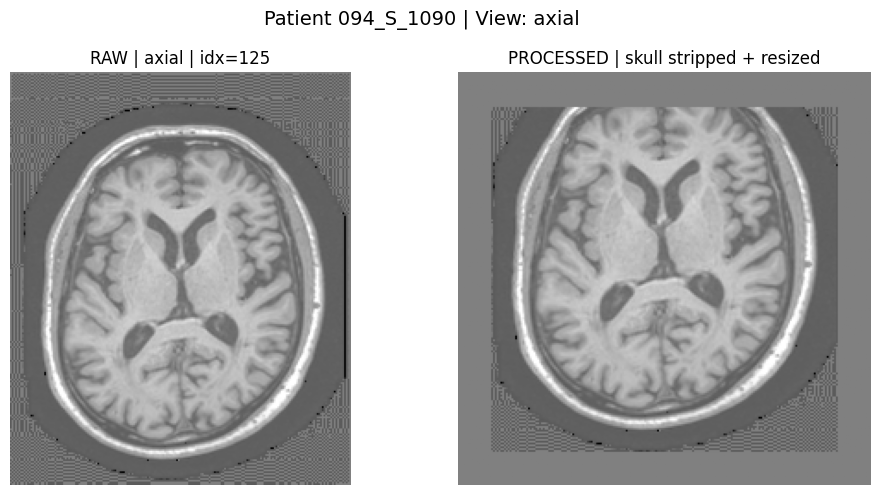


3. 8-fold Training sử dụng train_model function...
⚖️ Class weights: CN=0.9006, AD=1.1241


BẮT ĐẦU FOLD 1/8

📊 Phân bố label Fold 1:
  Train: AD=120, CN=141, ratio=0.85
  Val:   AD=13, CN=25, ratio=0.52
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 169MB/s]


Epoch 01/15 | train_loss=0.7158, train_acc=0.4789 | val_loss=0.6807, val_acc=0.3421
  ✅ Đã lưu best model (epoch=1, val_acc=0.3421)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.3421.pth
Epoch 02/15 | train_loss=0.6953, train_acc=0.5517 | val_loss=0.7244, val_acc=0.3421
  ⏸️  Không cải thiện (best=0.3421 @ epoch=1)
Epoch 03/15 | train_loss=0.7090, train_acc=0.4904 | val_loss=0.6767, val_acc=0.3421
  ⏸️  Không cải thiện (best=0.3421 @ epoch=1)
Epoch 04/15 | train_loss=0.6952, train_acc=0.5364 | val_loss=0.7380, val_acc=0.3421
  ⏸️  Không cải thiện (best=0.3421 @ epoch=1)
Epoch 05/15 | train_loss=0.6983, train_acc=0.5287 | val_loss=0.6471, val_acc=0.4737
  ✅ Đã lưu best model (epoch=5, val_acc=0.4737)
  📁 Lưu checkpoint: best_axial_epoch5_acc0.4737.pth
Epoch 06/15 | train_loss=0.7087, train_acc=0.4943 | val_loss=0.7148, val_acc=0.3421
  ⏸️  Không cải thiện (best=0.4737 @ epoch=5)
Epoch 07/15 | train_loss=0.7008, train_acc=0.4713 | val_loss=0.7214, val_acc=0.3421
  ⏸️  Không cải thiện (best=

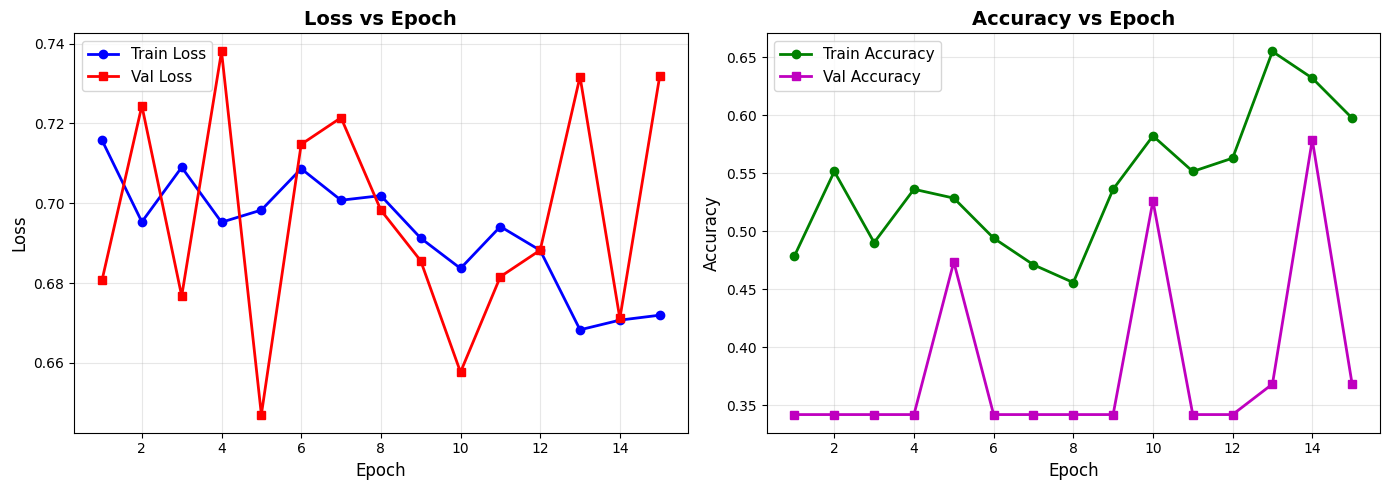


🎯 Kết thúc Fold 1:
   Accuracy=0.5789
   F1-score=0.6000
   Best accuracy trong fold=0.5789
   🏆 Đây là model tốt nhất overall cho đến nay! (acc=0.5789)

BẮT ĐẦU FOLD 2/8

📊 Phân bố label Fold 2:
  Train: AD=114, CN=147, ratio=0.78
  Val:   AD=19, CN=19, ratio=1.00
Epoch 01/15 | train_loss=0.7337, train_acc=0.4866 | val_loss=0.6943, val_acc=0.5000
  ✅ Đã lưu best model (epoch=1, val_acc=0.5000)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.5000.pth
Epoch 02/15 | train_loss=0.6940, train_acc=0.5556 | val_loss=0.7052, val_acc=0.5000
  ⏸️  Không cải thiện (best=0.5000 @ epoch=1)
Epoch 03/15 | train_loss=0.6898, train_acc=0.5670 | val_loss=0.6979, val_acc=0.5789
  ✅ Đã lưu best model (epoch=3, val_acc=0.5789)
  📁 Lưu checkpoint: best_axial_epoch3_acc0.5789.pth
Epoch 04/15 | train_loss=0.6906, train_acc=0.5517 | val_loss=0.6946, val_acc=0.4474
  ⏸️  Không cải thiện (best=0.5789 @ epoch=3)
Epoch 05/15 | train_loss=0.6304, train_acc=0.6437 | val_loss=0.7801, val_acc=0.5263
  ⏸️  Không cải thiện

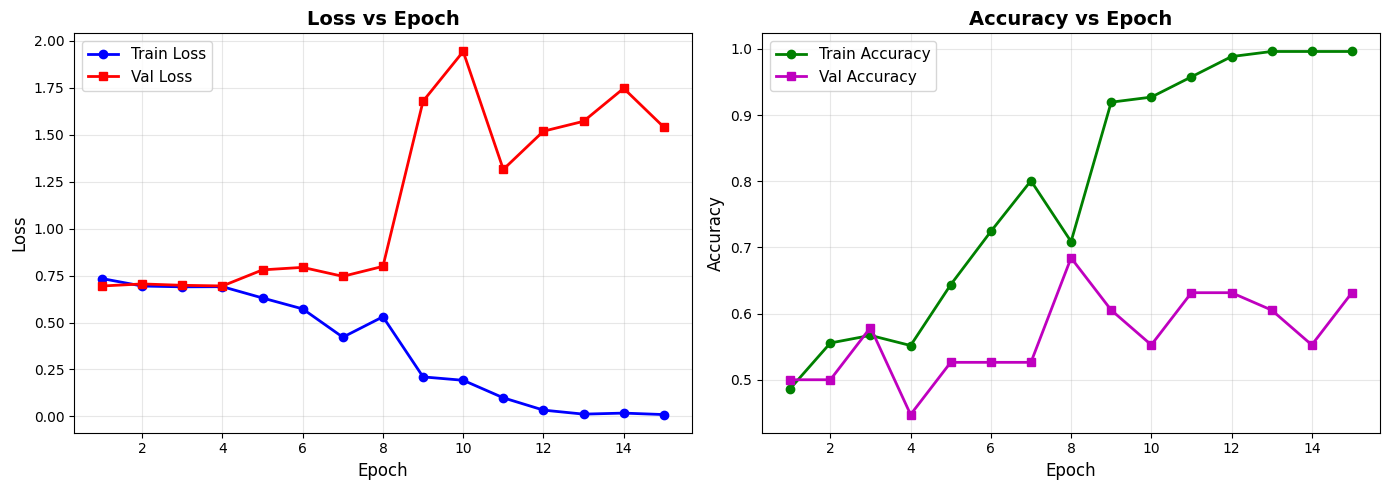


🎯 Kết thúc Fold 2:
   Accuracy=0.6842
   F1-score=0.6842
   Best accuracy trong fold=0.6842
   🏆 Đây là model tốt nhất overall cho đến nay! (acc=0.6842)

BẮT ĐẦU FOLD 3/8

📊 Phân bố label Fold 3:
  Train: AD=116, CN=145, ratio=0.80
  Val:   AD=17, CN=21, ratio=0.81
Epoch 01/15 | train_loss=0.7169, train_acc=0.5517 | val_loss=0.6927, val_acc=0.5526
  ✅ Đã lưu best model (epoch=1, val_acc=0.5526)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.5526.pth
Epoch 02/15 | train_loss=0.7019, train_acc=0.5249 | val_loss=0.6951, val_acc=0.5526
  ⏸️  Không cải thiện (best=0.5526 @ epoch=1)
Epoch 03/15 | train_loss=0.7016, train_acc=0.5019 | val_loss=0.6831, val_acc=0.4474
  ⏸️  Không cải thiện (best=0.5526 @ epoch=1)
Epoch 04/15 | train_loss=0.6987, train_acc=0.5632 | val_loss=0.6866, val_acc=0.4474
  ⏸️  Không cải thiện (best=0.5526 @ epoch=1)
Epoch 05/15 | train_loss=0.6937, train_acc=0.5556 | val_loss=0.6873, val_acc=0.4474
  ⏸️  Không cải thiện (best=0.5526 @ epoch=1)
Epoch 06/15 | train_loss=0.68

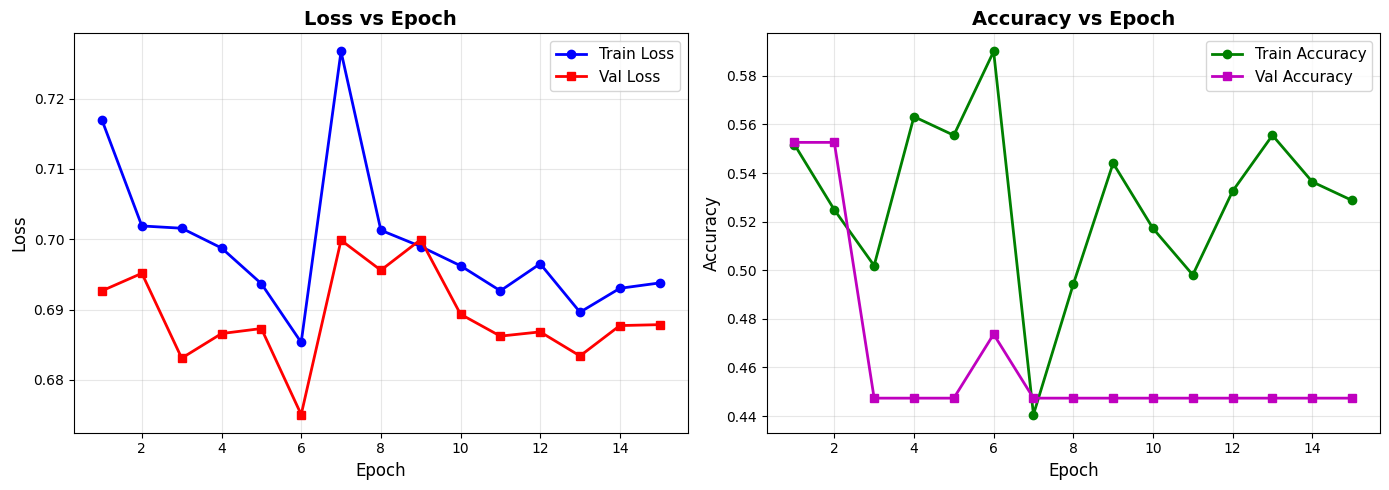


🎯 Kết thúc Fold 3:
   Accuracy=0.5526
   F1-score=0.0000
   Best accuracy trong fold=0.5526

BẮT ĐẦU FOLD 4/8

📊 Phân bố label Fold 4:
  Train: AD=118, CN=144, ratio=0.82
  Val:   AD=15, CN=22, ratio=0.68
Epoch 01/15 | train_loss=0.7124, train_acc=0.5191 | val_loss=0.6971, val_acc=0.4054
  ✅ Đã lưu best model (epoch=1, val_acc=0.4054)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.4054.pth
Epoch 02/15 | train_loss=0.7061, train_acc=0.4198 | val_loss=0.6698, val_acc=0.4054
  ⏸️  Không cải thiện (best=0.4054 @ epoch=1)
Epoch 03/15 | train_loss=0.6950, train_acc=0.5344 | val_loss=0.7162, val_acc=0.4054
  ⏸️  Không cải thiện (best=0.4054 @ epoch=1)
Epoch 04/15 | train_loss=0.7107, train_acc=0.5076 | val_loss=0.6753, val_acc=0.4054
  ⏸️  Không cải thiện (best=0.4054 @ epoch=1)
Epoch 05/15 | train_loss=0.7025, train_acc=0.4733 | val_loss=0.6806, val_acc=0.4054
  ⏸️  Không cải thiện (best=0.4054 @ epoch=1)
Epoch 06/15 | train_loss=0.6900, train_acc=0.5344 | val_loss=0.6747, val_acc=0.3784
  ⏸️  

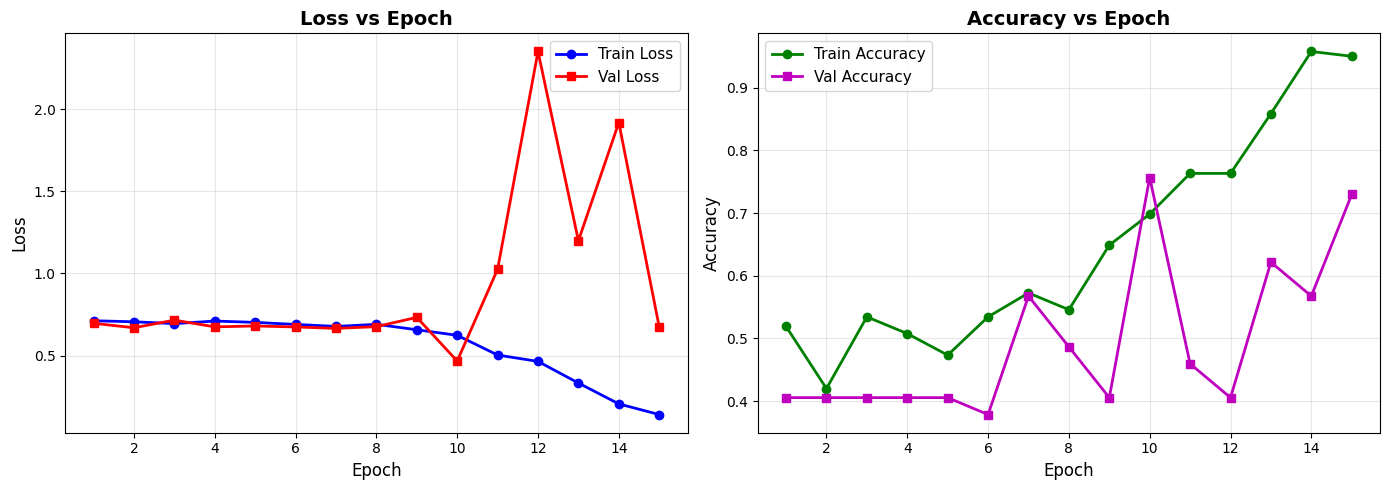


🎯 Kết thúc Fold 4:
   Accuracy=0.7568
   F1-score=0.7568
   Best accuracy trong fold=0.7568
   🏆 Đây là model tốt nhất overall cho đến nay! (acc=0.7568)

BẮT ĐẦU FOLD 5/8

📊 Phân bố label Fold 5:
  Train: AD=116, CN=146, ratio=0.79
  Val:   AD=17, CN=20, ratio=0.85
Epoch 01/15 | train_loss=0.7273, train_acc=0.4809 | val_loss=0.7062, val_acc=0.4595
  ✅ Đã lưu best model (epoch=1, val_acc=0.4595)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.4595.pth
Epoch 02/15 | train_loss=0.6935, train_acc=0.5573 | val_loss=0.7115, val_acc=0.4595
  ⏸️  Không cải thiện (best=0.4595 @ epoch=1)
Epoch 03/15 | train_loss=0.6908, train_acc=0.5611 | val_loss=0.6805, val_acc=0.4595
  ⏸️  Không cải thiện (best=0.4595 @ epoch=1)
Epoch 04/15 | train_loss=0.6910, train_acc=0.5534 | val_loss=0.6671, val_acc=0.6216
  ✅ Đã lưu best model (epoch=4, val_acc=0.6216)
  📁 Lưu checkpoint: best_axial_epoch4_acc0.6216.pth
Epoch 05/15 | train_loss=0.6463, train_acc=0.5954 | val_loss=0.7468, val_acc=0.4865
  ⏸️  Không cải thiện

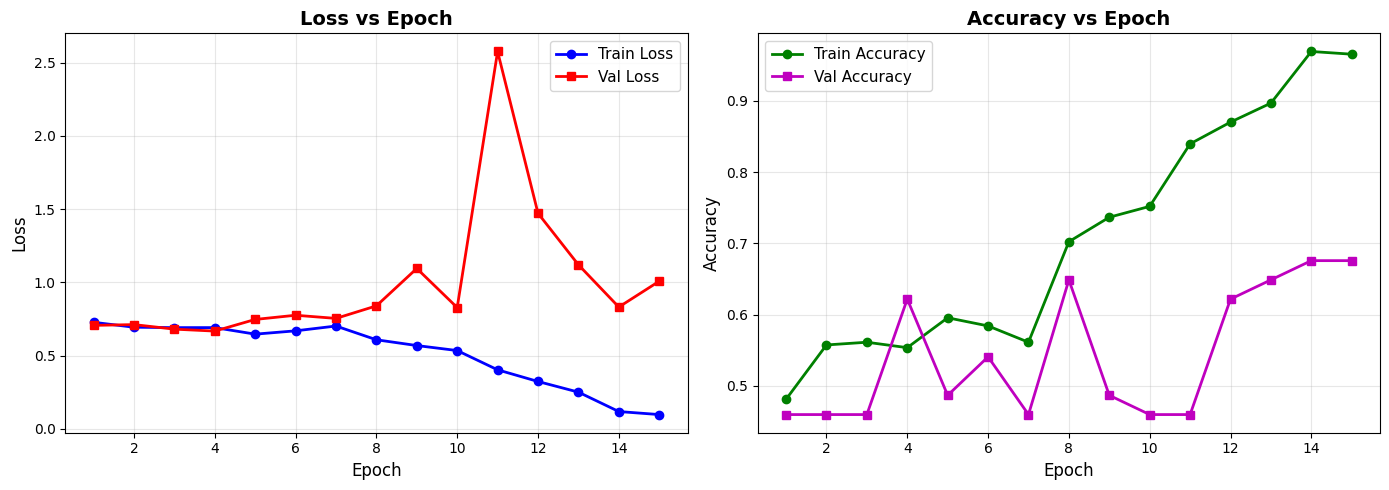


🎯 Kết thúc Fold 5:
   Accuracy=0.6757
   F1-score=0.6471
   Best accuracy trong fold=0.6757

BẮT ĐẦU FOLD 6/8

📊 Phân bố label Fold 6:
  Train: AD=124, CN=138, ratio=0.90
  Val:   AD=9, CN=28, ratio=0.32
Epoch 01/15 | train_loss=0.7089, train_acc=0.5267 | val_loss=0.5590, val_acc=0.7568
  ✅ Đã lưu best model (epoch=1, val_acc=0.7568)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.7568.pth
Epoch 02/15 | train_loss=0.7034, train_acc=0.4885 | val_loss=0.7292, val_acc=0.2432
  ⏸️  Không cải thiện (best=0.7568 @ epoch=1)
Epoch 03/15 | train_loss=0.6873, train_acc=0.5534 | val_loss=1.2280, val_acc=0.2432
  ⏸️  Không cải thiện (best=0.7568 @ epoch=1)
Epoch 04/15 | train_loss=0.6977, train_acc=0.5191 | val_loss=0.7231, val_acc=0.2432
  ⏸️  Không cải thiện (best=0.7568 @ epoch=1)
Epoch 05/15 | train_loss=0.6965, train_acc=0.5000 | val_loss=0.7006, val_acc=0.2432
  ⏸️  Không cải thiện (best=0.7568 @ epoch=1)
Epoch 06/15 | train_loss=0.6883, train_acc=0.5344 | val_loss=0.8044, val_acc=0.2432
  ⏸️  K

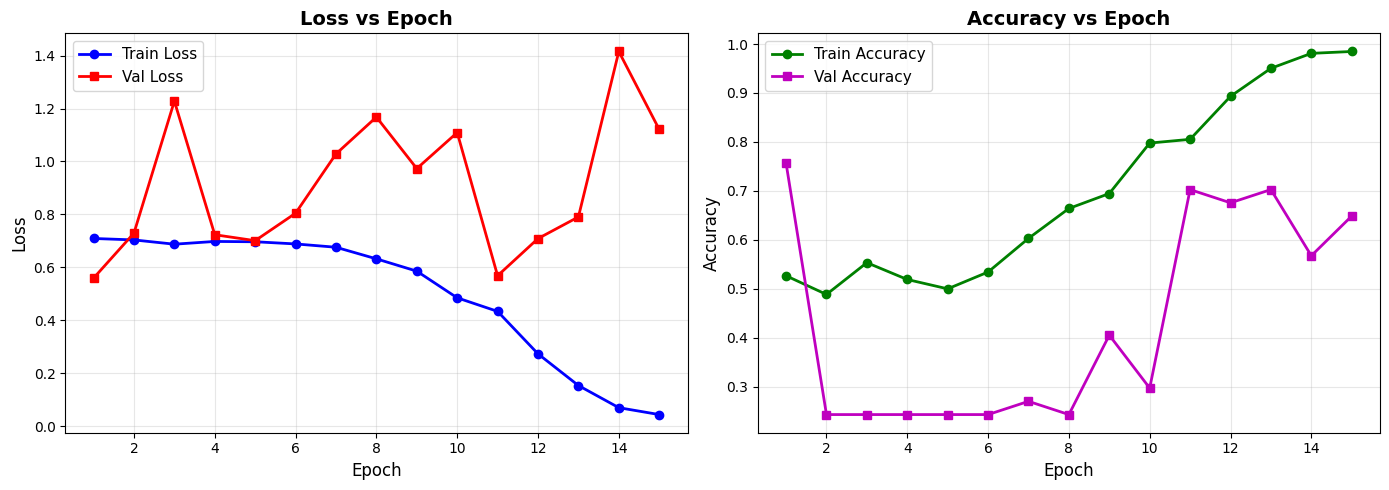


🎯 Kết thúc Fold 6:
   Accuracy=0.7568
   F1-score=0.0000
   Best accuracy trong fold=0.7568

BẮT ĐẦU FOLD 7/8

📊 Phân bố label Fold 7:
  Train: AD=113, CN=149, ratio=0.76
  Val:   AD=20, CN=17, ratio=1.18
Epoch 01/15 | train_loss=0.7276, train_acc=0.5344 | val_loss=0.6888, val_acc=0.5405
  ✅ Đã lưu best model (epoch=1, val_acc=0.5405)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.5405.pth
Epoch 02/15 | train_loss=0.7048, train_acc=0.5267 | val_loss=0.6958, val_acc=0.5405
  ⏸️  Không cải thiện (best=0.5405 @ epoch=1)
Epoch 03/15 | train_loss=0.6971, train_acc=0.5153 | val_loss=0.6889, val_acc=0.5405
  ⏸️  Không cải thiện (best=0.5405 @ epoch=1)
Epoch 04/15 | train_loss=0.7000, train_acc=0.5115 | val_loss=0.6944, val_acc=0.5405
  ⏸️  Không cải thiện (best=0.5405 @ epoch=1)
Epoch 05/15 | train_loss=0.7022, train_acc=0.5458 | val_loss=0.6932, val_acc=0.5405
  ⏸️  Không cải thiện (best=0.5405 @ epoch=1)
Epoch 06/15 | train_loss=0.6960, train_acc=0.4809 | val_loss=0.6943, val_acc=0.5405
  ⏸️  

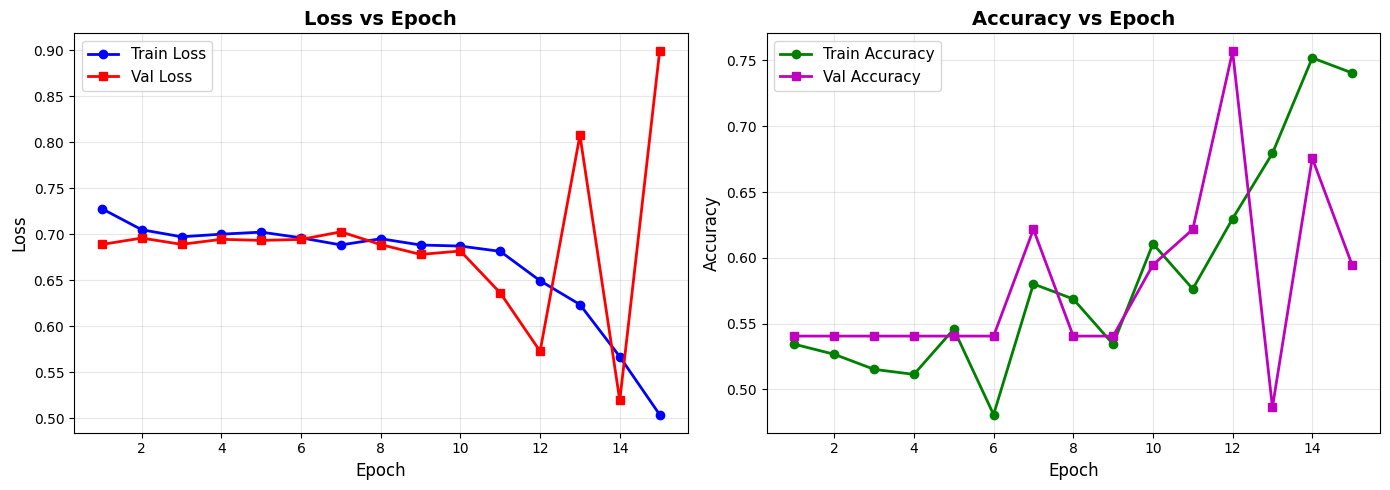


🎯 Kết thúc Fold 7:
   Accuracy=0.7568
   F1-score=0.8000
   Best accuracy trong fold=0.7568

BẮT ĐẦU FOLD 8/8

📊 Phân bố label Fold 8:
  Train: AD=110, CN=152, ratio=0.72
  Val:   AD=23, CN=14, ratio=1.64
Epoch 01/15 | train_loss=0.7254, train_acc=0.4847 | val_loss=0.7099, val_acc=0.6216
  ✅ Đã lưu best model (epoch=1, val_acc=0.6216)
  📁 Lưu checkpoint: best_axial_epoch1_acc0.6216.pth
Epoch 02/15 | train_loss=0.6939, train_acc=0.5267 | val_loss=0.7009, val_acc=0.6216
  ⏸️  Không cải thiện (best=0.6216 @ epoch=1)
Epoch 03/15 | train_loss=0.6737, train_acc=0.6260 | val_loss=0.7780, val_acc=0.4595
  ⏸️  Không cải thiện (best=0.6216 @ epoch=1)
Epoch 04/15 | train_loss=0.6847, train_acc=0.5344 | val_loss=0.6917, val_acc=0.6216
  ⏸️  Không cải thiện (best=0.6216 @ epoch=1)
Epoch 05/15 | train_loss=0.6963, train_acc=0.5496 | val_loss=0.6820, val_acc=0.6216
  ⏸️  Không cải thiện (best=0.6216 @ epoch=1)
Epoch 06/15 | train_loss=0.6680, train_acc=0.6069 | val_loss=1.1211, val_acc=0.5676
  ⏸️  

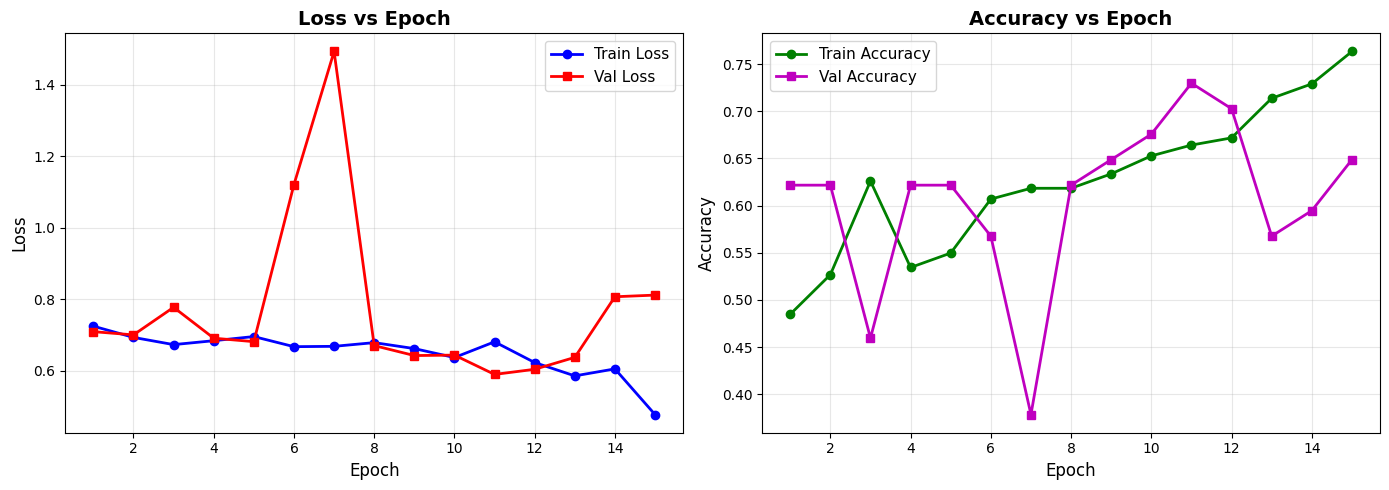


🎯 Kết thúc Fold 8:
   Accuracy=0.7297
   F1-score=0.8077
   Best accuracy trong fold=0.7297

TỔNG KẾT AXIAL VIEW (8-fold)
📊 Kết quả từng fold:
  Fold 1: Acc=0.5789, F1=0.6000
  Fold 2: Acc=0.6842, F1=0.6842
  Fold 3: Acc=0.5526, F1=0.0000
  Fold 4: Acc=0.7568, F1=0.7568
  Fold 5: Acc=0.6757, F1=0.6471
  Fold 6: Acc=0.7568, F1=0.0000
  Fold 7: Acc=0.7568, F1=0.8000
  Fold 8: Acc=0.7297, F1=0.8077

📈 Thống kê:
  Trung bình Accuracy:   0.6864 ± 0.0761
  Trung bình F1-score:   0.5370 ± 0.3173
  Model tốt nhất overall: 0.7568

ĐÁNH GIÁ TRÊN TEST SET
📥 Đang load best overall model: best_axial_overall_model.pth

🎯 Kết quả Test Set cuối cùng:
  Accuracy:  0.6933
  Precision: 0.6316
  Recall:    0.7273
  F1-score:  0.6761


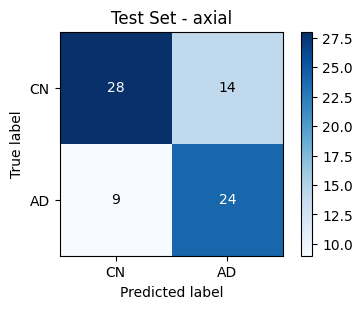


💾 Đã lưu kết quả vào: /kaggle/working/axial_final_results.npy


In [20]:
if __name__ == "__main__":
    main()

==== PATIENT QUERY ====
Patient ID: 003_S_1257
True Label: AD
File: ADNI_003_S_1257_MR_MPR__GradWarp__B1_Correction_Br_20070501172334212_S27340_I52791.nii

==== MODEL PREDICTION ====
Prediction : AD
P(AD)      : 0.7427

==== TOP 5 SLICES (ATTENTION) ====
Top 1: view=axial, slice=8, attn=0.2218


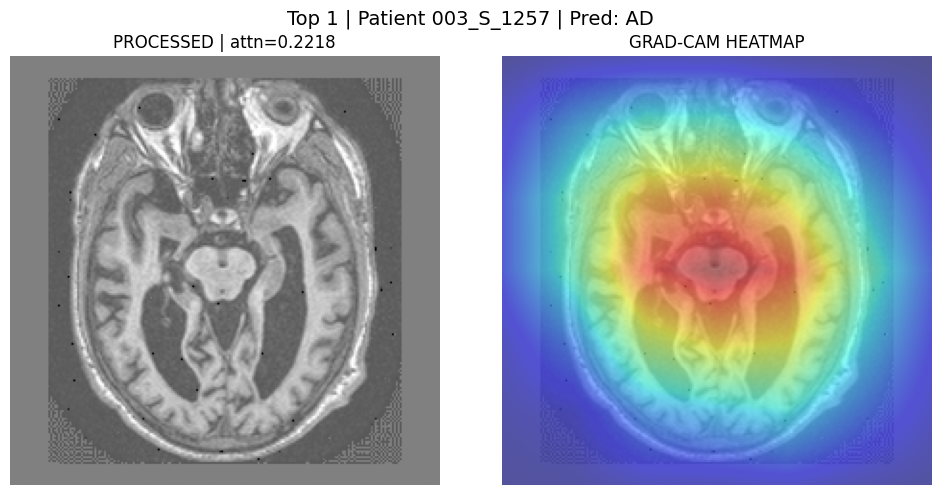

Top 2: view=axial, slice=9, attn=0.0757


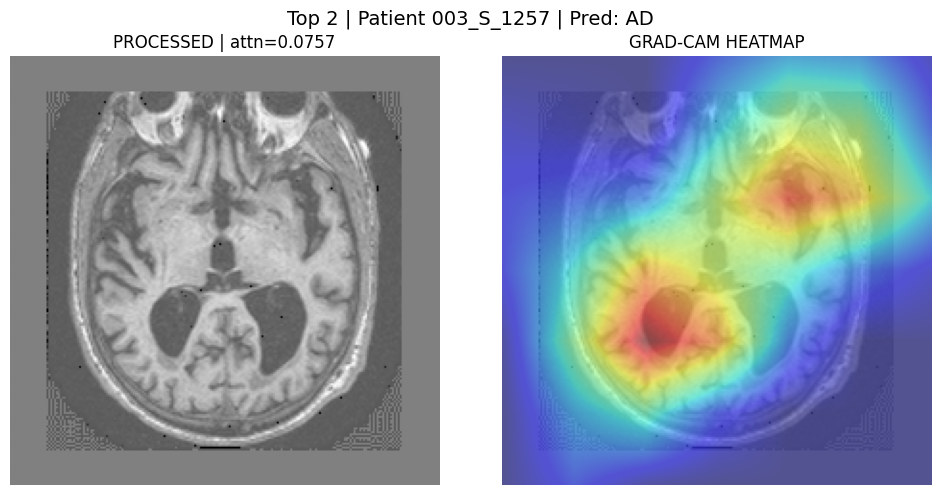

Top 3: view=axial, slice=0, attn=0.0732


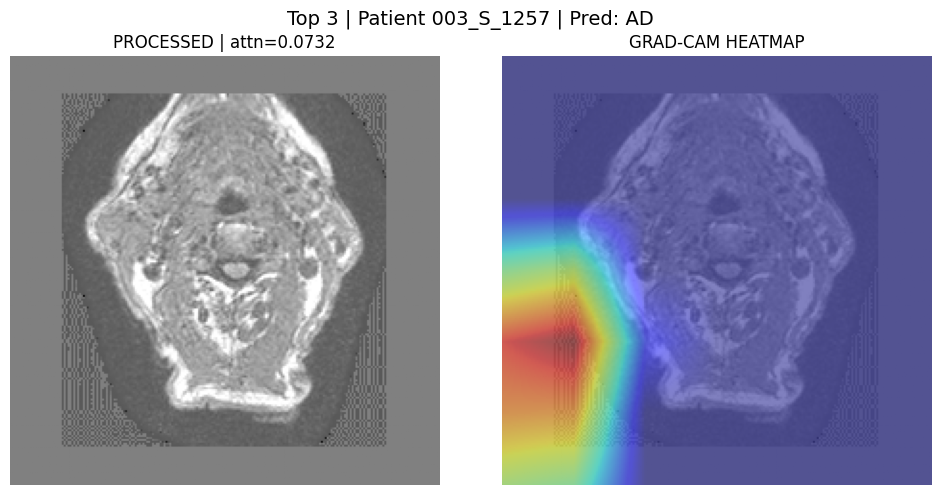

Top 4: view=axial, slice=1, attn=0.0706


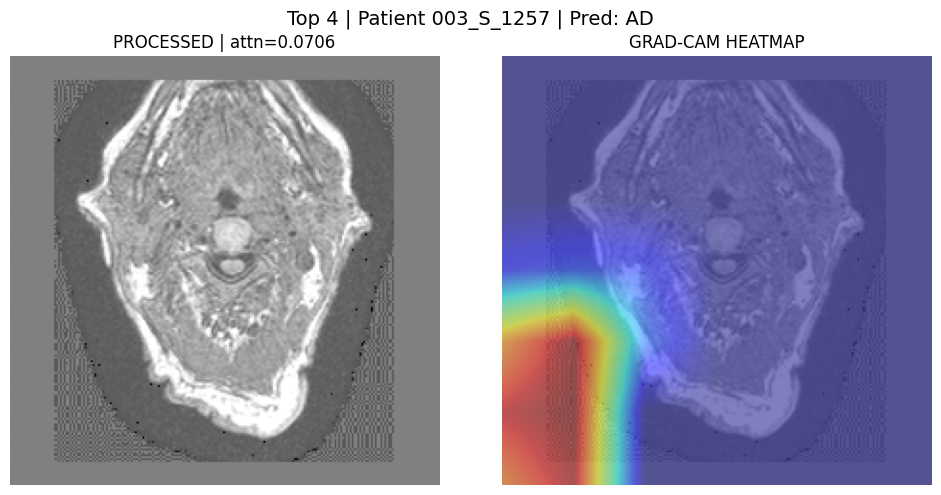

Top 5: view=axial, slice=3, attn=0.0695


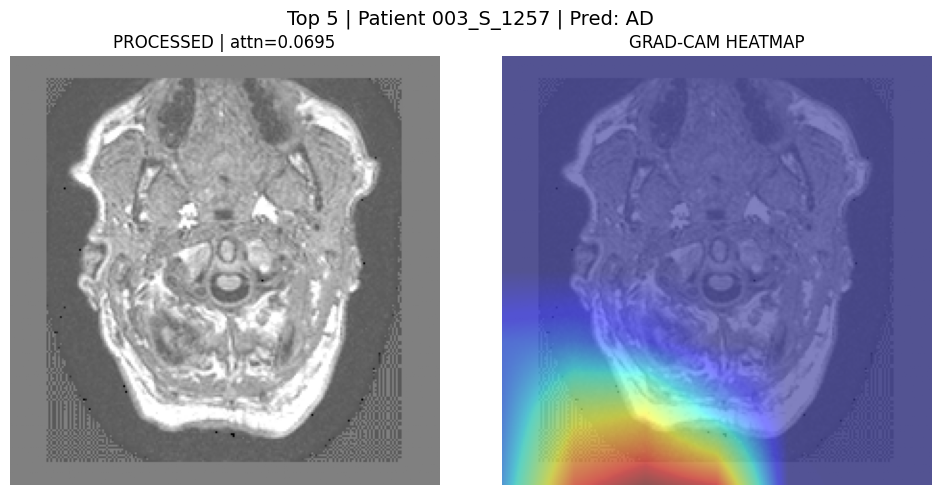

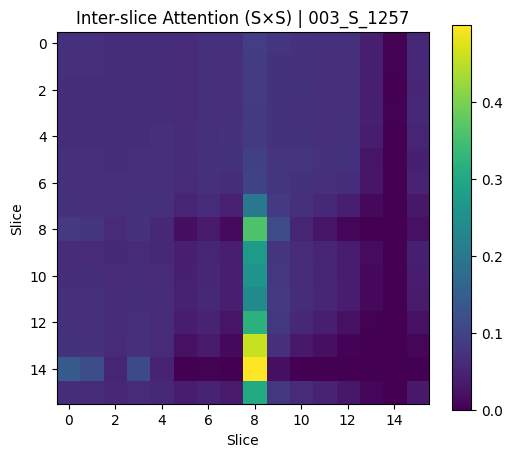

In [22]:
patient_id_to_check = "003_S_1257"
query_patient(patient_id_to_check, topK)